Use iNNvestigate with the basic model, and analyze the results.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

import innvestigate
import innvestigate.utils as iutils

import numpy as np
import pandas as pd
import time
import os
import pickle

from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Load data

In [3]:
pklfile = '../../data/breast_cyto.pkl'
with open(pklfile, 'rb') as fi:
    feat_mat = pickle.load(fi)

In [191]:
feat_mat.shape

(6250, 1622)

Scale data

In [5]:
feat_scaled = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_mat))

Load Model

In [8]:
modelpath = '../../data/'
model = keras.models.load_model(modelpath)

Global params

In [6]:
early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss', patience=20,mode='min')
input_size = feat_mat.shape[1]
hidden_size = 800
output_size = input_size
epochs = 2000
batch_size = 128

Test plots

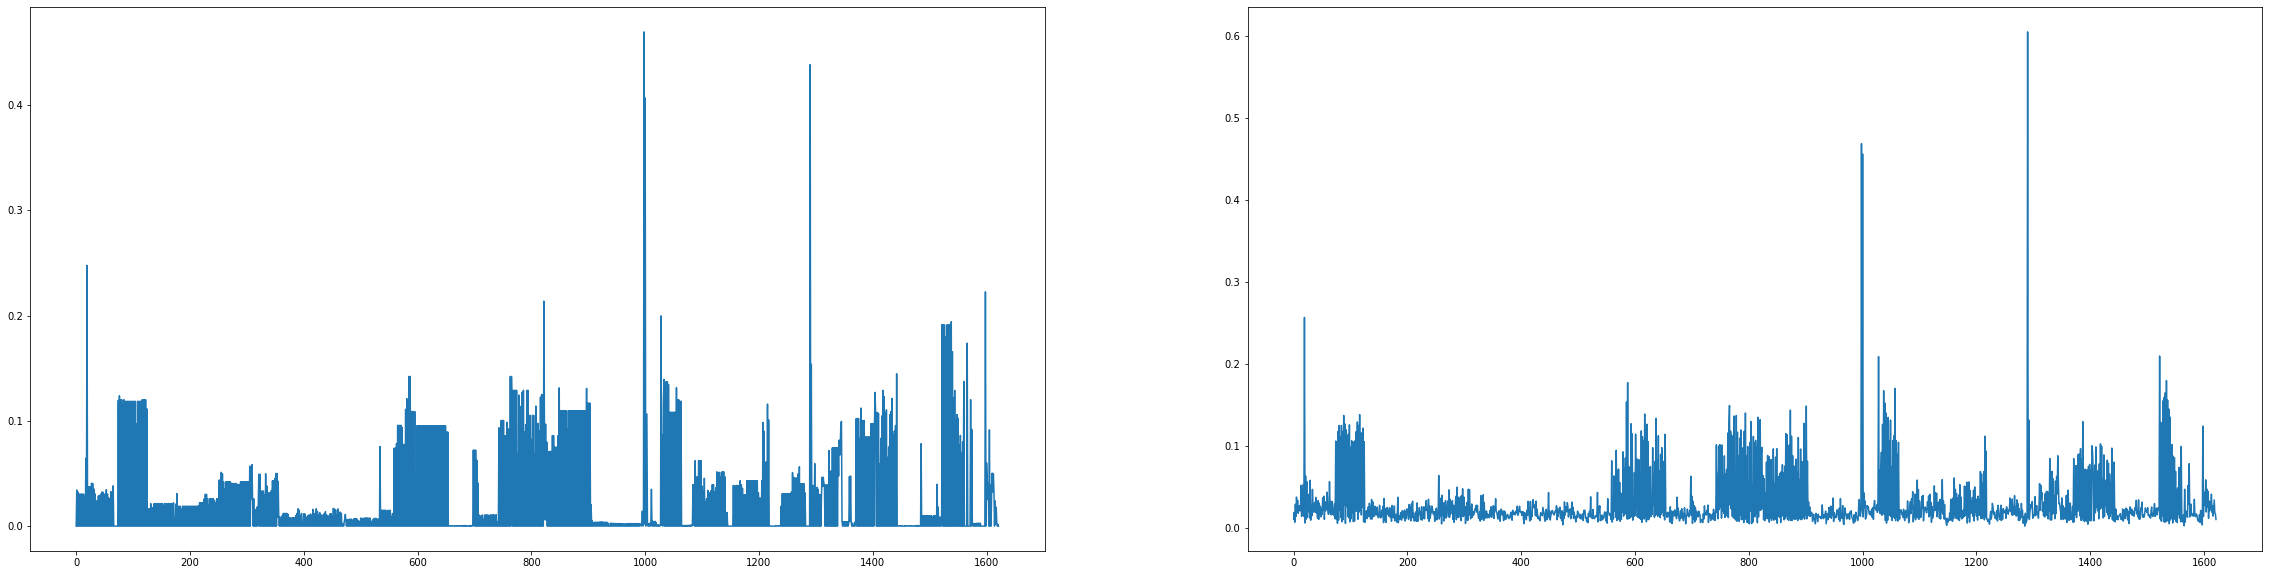

In [9]:
idx = 1234
plt.figure(figsize=(40,10))

pltrows = 1
pltcols = 2 

plt.subplot(pltrows,pltcols, 1)
sns.lineplot(x=range(input_size),y=np.abs(feat_scaled[idx]))


decoded = model.predict(feat_scaled[idx].reshape(1,input_size,))
plt.subplot(pltrows,pltcols, 2)
sns.lineplot(x=range(input_size),y=decoded[0])

In [40]:
x = model.get_layer(index=0).input
h = model.get_layer(index=1).output
encoder = Model(x,h)

In [46]:
x = model.layers[0]

In [48]:
x.output

<tf.Tensor 'input_1_1:0' shape=(?, 1622) dtype=float32>

In [37]:
recon = Model(model.get_layer(index=0).input, model.get_layer(index=2).output)

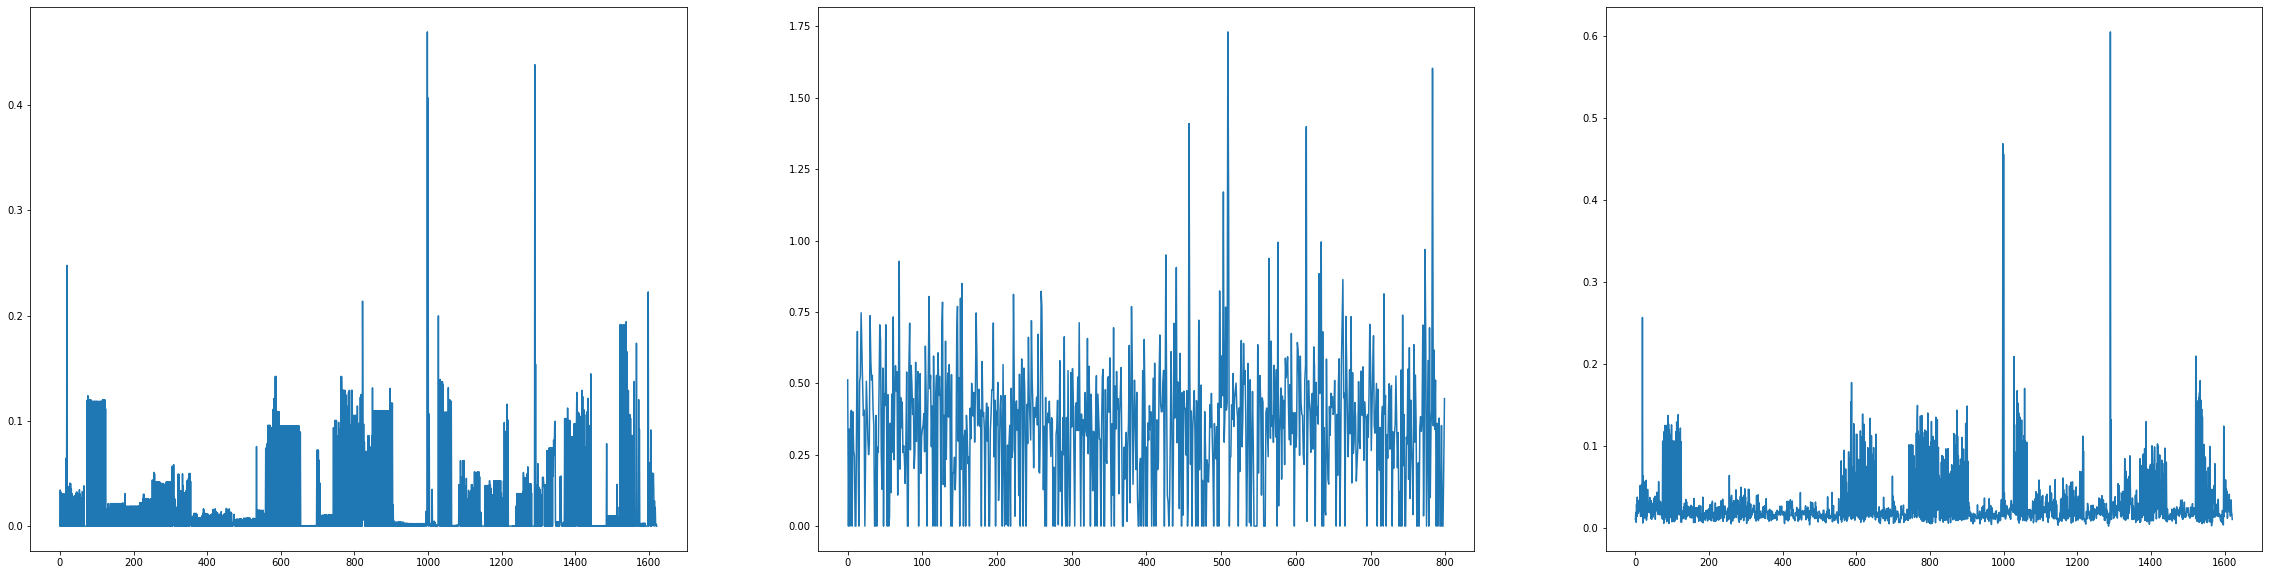

In [42]:
idx = 1234
plt.figure(figsize=(40,10))

pltrows = 1
pltcols = 3 

plt.subplot(pltrows,pltcols, 1)
sns.lineplot(x=range(input_size),y=np.abs(feat_scaled[idx]))


decoded = encoder.predict(feat_scaled[idx].reshape(1,input_size,))
plt.subplot(pltrows,pltcols, 2)
sns.lineplot(x=range(hidden_size),y=decoded[0])

decoded = recon.predict(feat_scaled[idx].reshape(1,input_size,))
plt.subplot(pltrows,pltcols, 3)
sns.lineplot(x=range(input_size),y=decoded[0])

In [31]:
decoded[0].shape

(800,)

iNNvestigate

In [49]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(feat_scaled[idx].reshape(1,input_size,))

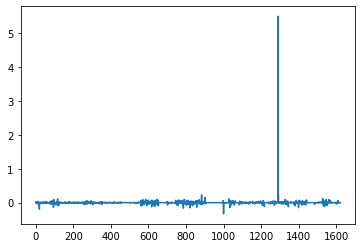

In [52]:
sns.lineplot(x=range(input_size),y=analysis[0])

In [109]:
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model, neuron_selection_mode="index")
i = 0
analysis = np.zeros(input_size)
for neuron_index in range(input_size):
    analysis += gradient_analyzer.analyze(feat_scaled[idx].reshape(1,input_size,), neuron_index)[0]
    i +=1
print(i)

1622


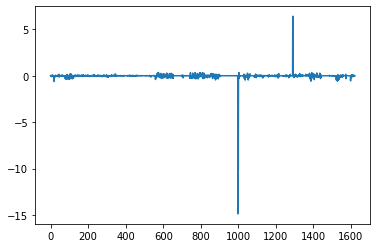

In [110]:
sns.lineplot(x=range(input_size),y=analysis)

In [105]:
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", encoder, neuron_selection_mode="index")
i = 0
analysis = np.zeros(input_size)
for neuron_index in range(hidden_size):
    analysis += gradient_analyzer.analyze(feat_scaled[idx].reshape(1,input_size,), neuron_index)[0]
    i +=1
print(i)

800


In [156]:
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", encoder, neuron_selection_mode="index")
i = 0
analysis = np.zeros(input_size)
for neuron_index in range(hidden_size):
    analysis = np.add(analysis, gradient_analyzer.analyze(feat_scaled, neuron_index))
    i +=1
print(i)

800


array([0.        , 0.        , 0.        , ..., 0.01301994, 0.        ,
       0.        ])

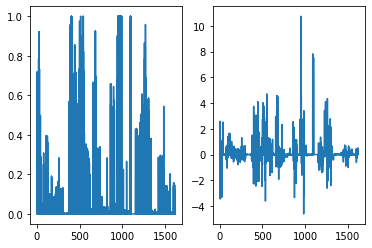

In [166]:
index = 444
plt.subplot(1,2, 1)
sns.lineplot(x=range(input_size),y=np.abs(feat_scaled[index]))
plt.subplot(1,2, 2)
sns.lineplot(x=range(input_size),y=analysis[index])

Analyze LRP result

In [111]:
df = pd.DataFrame({'idx':range(input_size), 'value':feat_scaled[idx], 'weight':analysis})

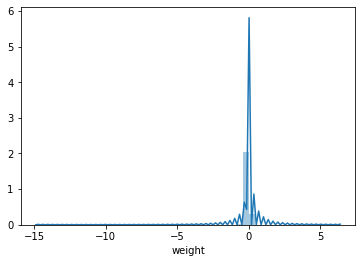

In [114]:
sns.distplot(df['weight'])

In [115]:
df1 = df[df['weight'] != 0]

In [119]:
dfp = df[df['weight'] > 0]
dfn = df[df['weight'] < 0]

In [149]:
df.iloc[0]

idx       0.0
value     0.0
weight    0.0
Name: 0, dtype: float64

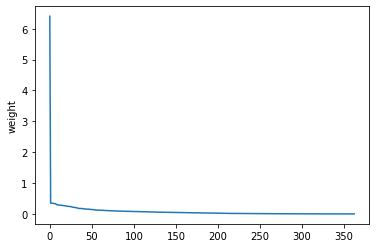

In [173]:
sns.lineplot(x=range(dfp.shape[0]),y=dfp['weight'])

In [121]:
dfn.shape

(446, 3)

In [123]:
dfp = dfp.sort_values('weight', ascending=False)

In [125]:
dfp.head(20)

,idx,value,weight
1290,1290,0.438459,6.403958
1391,1391,0.084739,0.348566
575,575,0.077528,0.348253
1003,1003,0.106529,0.347049
796,796,0.105237,0.341038
770,770,0.129026,0.337423
810,810,0.095297,0.333236
745,745,0.083979,0.327349
1418,1418,0.128993,0.302859
569,569,0.095728,0.294089


In [132]:
a = [[1,2,3],[0,0,0]]
b = [[1,1,1],[2,2,2]]

In [127]:
a += b

In [128]:
a

[[1, 2, 3], [0, 0, 0], [1, 1, 1], [2, 2, 2]]

In [133]:
np.add(a,b)

array([[2, 3, 4],
       [2, 2, 2]])

Cytoband index map

In [268]:
cytobands = pd.read_csv('../data/cytoBand_hg38.txt', sep='\t', names=['chro', 'start', 'end', 'name', 'note'])

In [269]:
cytobands = cytobands[~cytobands['chro'].str.contains('_')]

In [270]:
cytobands = cytobands[~cytobands['chro'].str.contains('M')]

In [271]:
cytobands = cytobands[~cytobands['chro'].isin(['chrX', 'chrY'])]

In [272]:
cytobands['chr'] = cytobands['chro'].str.slice(3).astype(int)

In [273]:
cytobands = cytobands.sort_values('chr')

In [274]:
cytobands = cytobands.reset_index(drop=True)

In [288]:
cytobands

,chro,start,end,name,note,chr
0,chr1,0,2300000,p36.33,gneg,1
1,chr1,123400000,125100000,q11,acen,1
2,chr1,125100000,143200000,q12,gvar,1
3,chr1,143200000,147500000,q21.1,gneg,1
4,chr1,147500000,150600000,q21.2,gpos50,1
...,...,...,...,...,...,...
806,chr22,37200000,40600000,q13.1,gneg,22
807,chr22,40600000,43800000,q13.2,gpos50,22
808,chr22,43800000,48100000,q13.31,gneg,22
809,chr22,49100000,50818468,q13.33,gneg,22


In [290]:
bandfile = '../data/bands.pkl'
with open(bandfile, 'wb') as fo:
    pickle.dump(cytobands, fo)

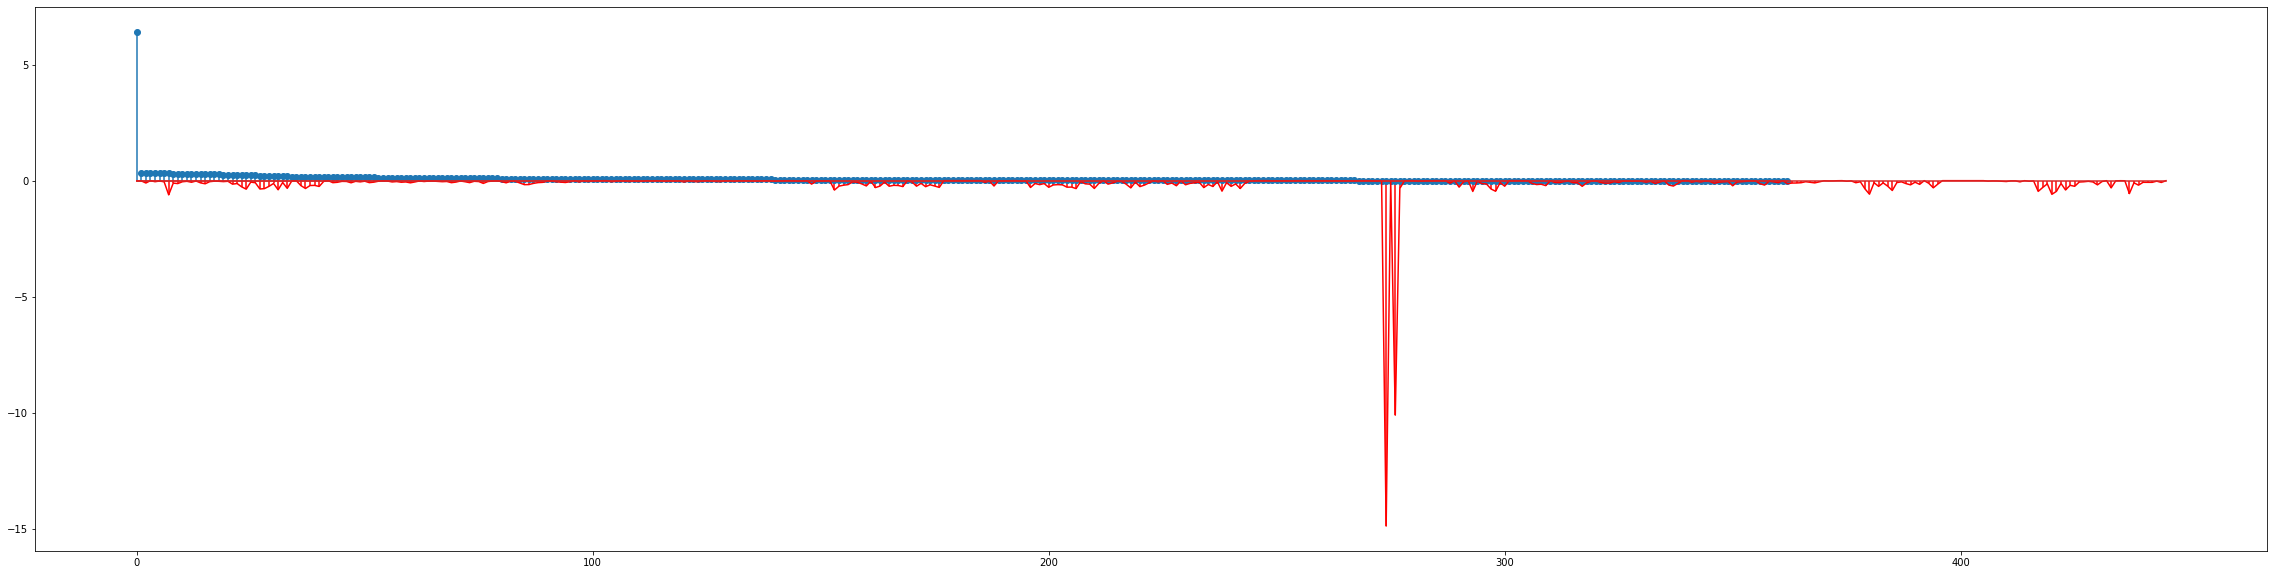

In [176]:
plt.figure(figsize=(40,10))
plt.stem(dfp['weight'], use_line_collection=True)
plt.stem(dfn['weight'], use_line_collection=True, linefmt='red', markerfmt='red')
plt.show()

In [180]:
analysis[:,np.all(analysis==0, axis=0)].shape

(6250, 30)

In [181]:
analysis.shape

(6250, 1622)

In [182]:
asum = np.sum(analysis, axis=0)

In [183]:
asum.shape

(1622,)

In [184]:
asum_p = asum[::2].copy()

asum_n = asum[1::2].copy()

In [1]:
import matplotlib
matplotlib.__version__

'3.1.1'

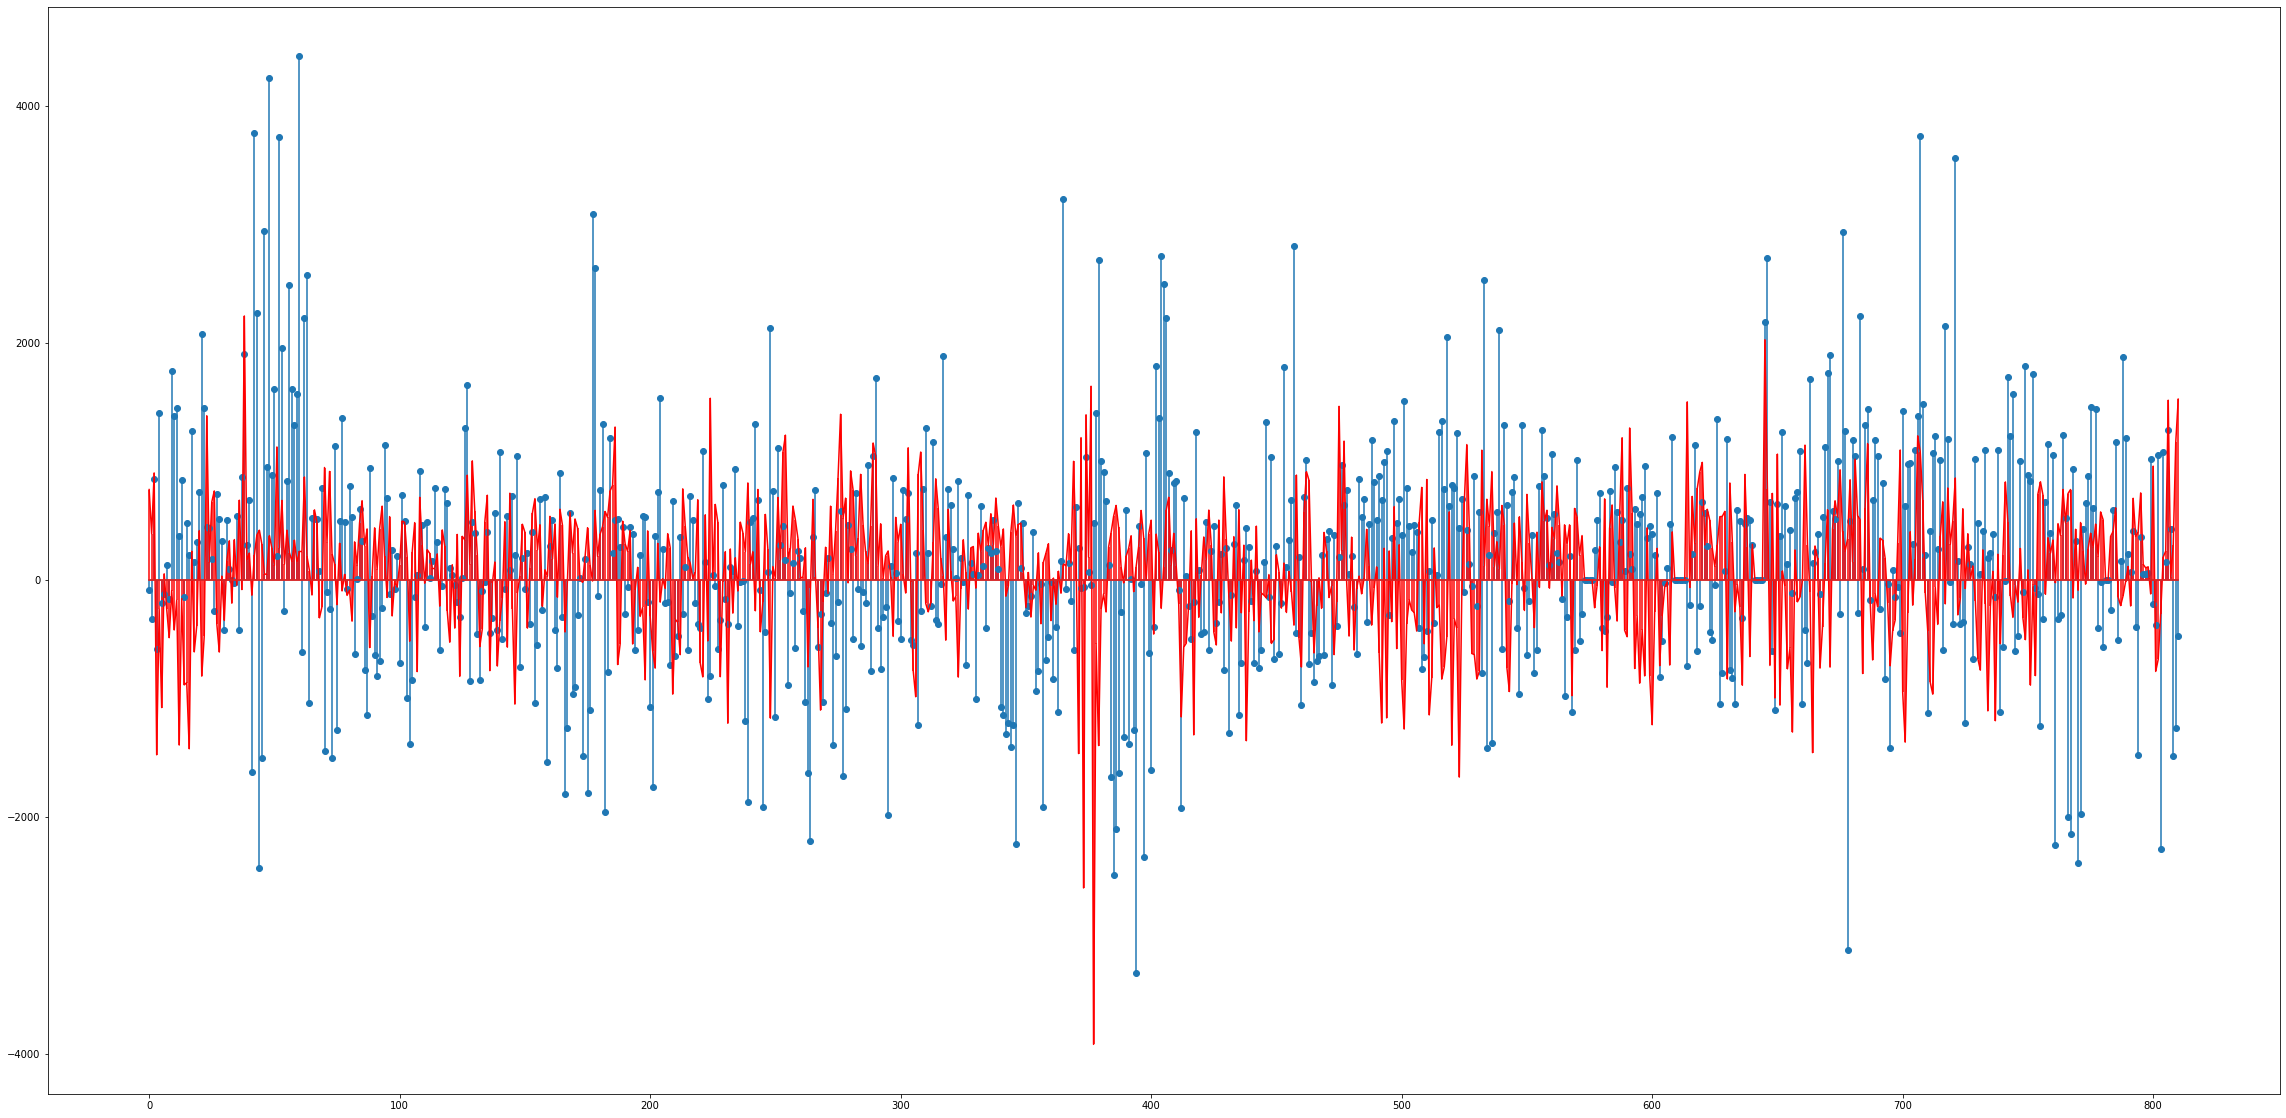

In [186]:
plt.figure(figsize=(40,20))
plt.stem(asum_p, use_line_collection=True)
plt.stem(asum_n, use_line_collection=True, linefmt='red', markerfmt='red')
plt.show()

In [189]:
dsum = pd.DataFrame({'index': range(asum_p.shape[0]), 'dup_weight':asum_p, 'del_weight':asum_n})

In [219]:
cytosum = pd.concat([cytobands, dsum], axis=1, sort=False, ignore_index=True)

In [276]:
cytosum = cytobands.join(dsum)

In [302]:
cytosum

,chro,start,end,name,note,chr,index,dup_weight,del_weight
0,chr1,0,2300000,p36.33,gneg,1,0,-83.987564,762.180839
1,chr1,123400000,125100000,q11,acen,1,1,-332.804352,389.541198
2,chr1,125100000,143200000,q12,gvar,1,2,852.044938,902.379627
3,chr1,143200000,147500000,q21.1,gneg,1,3,-584.894991,-1476.354542
4,chr1,147500000,150600000,q21.2,gpos50,1,4,1410.955072,-248.056468
...,...,...,...,...,...,...,...,...,...
806,chr22,37200000,40600000,q13.1,gneg,22,806,1266.838790,1515.884046
807,chr22,40600000,43800000,q13.2,gpos50,22,807,425.815432,22.869666
808,chr22,43800000,48100000,q13.31,gneg,22,808,-1484.614230,298.313582
809,chr22,49100000,50818468,q13.33,gneg,22,809,-1248.123421,1160.163589


In [237]:
dsum.shape

(811, 3)

In [239]:
cytobands.shape

(811, 6)

In [330]:
weights = np.vstack((asum_p, asum_n)).T

In [333]:
weights = preprocessing.MaxAbsScaler().fit_transform(weights)

In [335]:
weights = pd.DataFrame(weights, columns=['dup_scaled','del_scaled'])

In [338]:
weights

,dup_scaled,del_scaled
0,-0.018998,0.194415
1,-0.075280,0.099363
2,0.192732,0.230177
3,-0.132303,-0.376585
4,0.319157,-0.063274
...,...,...
806,0.286558,0.386668
807,0.096319,0.005834
808,-0.335819,0.076093
809,-0.282325,0.295932


In [337]:
pd.concat([cytosum, weights], axis=1)

,chro,start,end,name,note,chr,index,dup_weight,del_weight,dup_scaled,del_scaled
0,chr1,0,2300000,p36.33,gneg,1,0,-83.987564,762.180839,-0.018998,0.194415
1,chr1,123400000,125100000,q11,acen,1,1,-332.804352,389.541198,-0.075280,0.099363
2,chr1,125100000,143200000,q12,gvar,1,2,852.044938,902.379627,0.192732,0.230177
3,chr1,143200000,147500000,q21.1,gneg,1,3,-584.894991,-1476.354542,-0.132303,-0.376585
4,chr1,147500000,150600000,q21.2,gpos50,1,4,1410.955072,-248.056468,0.319157,-0.063274
...,...,...,...,...,...,...,...,...,...,...,...
806,chr22,37200000,40600000,q13.1,gneg,22,806,1266.838790,1515.884046,0.286558,0.386668
807,chr22,40600000,43800000,q13.2,gpos50,22,807,425.815432,22.869666,0.096319,0.005834
808,chr22,43800000,48100000,q13.31,gneg,22,808,-1484.614230,298.313582,-0.335819,0.076093
809,chr22,49100000,50818468,q13.33,gneg,22,809,-1248.123421,1160.163589,-0.282325,0.295932


In [339]:
filepath = '../data/breast_bandsum.csv'
pd.concat([cytosum, weights], axis=1).to_csv(filepath, index=False)
    

In [278]:
cytosum.nlargest(20,'dup_weight')

,chro,start,end,name,note,chr,index,dup_weight,del_weight
60,chr1,58500000,60800000,p32.1,gneg,1,60,4420.878717,239.604902
48,chr1,50200000,55600000,p32.3,gneg,1,48,4234.035041,373.897467
42,chr1,29900000,32300000,p35.2,gneg,1,42,3773.915432,210.133771
707,chr17,49300000,52100000,q21.33,gneg,17,707,3747.943690,1082.310446
52,chr1,101800000,106700000,p21.1,gpos100,1,52,3735.388452,269.936099
721,chr17,22700000,25100000,p11.1,acen,17,721,3558.193193,859.680524
365,chr7,50500000,53900000,p12.1,gpos75,7,365,3212.039086,133.428593
177,chr3,87800000,90900000,p11.1,acen,3,177,3085.003492,-9.437244
46,chr1,43700000,46300000,p34.1,gneg,1,46,2940.920755,48.220153
676,chr16,74100000,79200000,q23.1,gpos75,16,676,2936.297666,410.084794


In [279]:
cytosum.nlargest(20,'del_weight')

,chro,start,end,name,note,chr,index,dup_weight,del_weight
38,chr1,15900000,20100000,p36.13,gneg,1,38,1909.588235,2227.026124
645,chr15,52600000,58800000,q21.3,gpos75,15,645,2174.028115,2027.252576
376,chr8,72000000,74600000,q21.11,gpos100,8,376,-39.986174,1633.866161
224,chr4,50000000,51800000,q11,acen,4,224,-814.709582,1532.338734
810,chr22,4300000,9400000,p12,stalk,22,810,-475.668481,1524.822596
806,chr22,37200000,40600000,q13.1,gneg,22,806,1266.838790,1515.884046
614,chr14,95800000,100900000,q32.2,gpos50,14,614,-730.661730,1502.346018
475,chr10,45500000,48600000,q11.22,gpos25,10,475,196.381292,1464.237294
276,chr5,33800000,38400000,p13.2,gpos25,5,276,577.286310,1397.557942
374,chr8,69600000,72000000,q13.3,gneg,8,374,1036.984031,1393.314391


In [282]:
top20 = pd.merge(cytosum.nlargest(20,'dup_weight'), cytosum.nlargest(20,'del_weight'), how='outer')

In [285]:
top20.sort_values('index')

,chro,start,end,name,note,chr,index,dup_weight,del_weight
30,chr1,223900000,224400000,q42.11,gneg,1,23,444.965613,1385.436772
20,chr1,15900000,20100000,p36.13,gneg,1,38,1909.588235,2227.026124
2,chr1,29900000,32300000,p35.2,gneg,1,42,3773.915432,210.133771
19,chr1,32300000,34300000,p35.1,gpos25,1,43,2250.921609,378.109892
8,chr1,43700000,46300000,p34.1,gneg,1,46,2940.920755,48.220153
1,chr1,50200000,55600000,p32.3,gneg,1,48,4234.035041,373.897467
4,chr1,101800000,106700000,p21.1,gpos100,1,52,3735.388452,269.936099
18,chr1,84400000,87900000,p22.3,gneg,1,56,2491.705837,229.403193
0,chr1,58500000,60800000,p32.1,gneg,1,60,4420.878717,239.604902
15,chr2,73300000,74800000,p13.1,gneg,2,63,2574.221452,200.059700


In [293]:
top20

,chro,start,end,name,note,chr,index,dup_weight,del_weight
0,chr1,58500000,60800000,p32.1,gneg,1,60,4420.878717,239.604902
1,chr1,50200000,55600000,p32.3,gneg,1,48,4234.035041,373.897467
2,chr1,29900000,32300000,p35.2,gneg,1,42,3773.915432,210.133771
3,chr17,49300000,52100000,q21.33,gneg,17,707,3747.943690,1082.310446
4,chr1,101800000,106700000,p21.1,gpos100,1,52,3735.388452,269.936099
5,chr17,22700000,25100000,p11.1,acen,17,721,3558.193193,859.680524
6,chr7,50500000,53900000,p12.1,gpos75,7,365,3212.039086,133.428593
7,chr3,87800000,90900000,p11.1,acen,3,177,3085.003492,-9.437244
8,chr1,43700000,46300000,p34.1,gneg,1,46,2940.920755,48.220153
9,chr16,74100000,79200000,q23.1,gpos75,16,676,2936.297666,410.084794
